# CPEN400D Deep Learning

Instructors: Brad Quinton, Scott Chin

# Assignment 4: Convolutional Neural Networks

In the previous assignment, you built a modular deep learning framework by implementing the forward and backward propagation of various layers required to build fully-connected neural networks. In this assignment, we will extend this framework by implementing layers that will let us build Convolutional Neural Networks (CNNs).  Specifically, in this assignment, you will implement the forward and backward propagation through three new layers: Convolutional layers, MaxPooling layers, and Flatten layer.  Simlar to last assignment, you will then use your framework to train some simple CNN models, as well as use the corresponding API in the Keras framework to further explore CNNs.

The goal of this assignment is 
- to help you better understand the forward and back propagation through convolutional neural network layers.
- introduce you to working with convolutional neural networks in a real deep learning framework, Keras.

Specifically, after this assignment you will have:

- Extended our deep learning framework to support Convolutional Neural Networks
- Implemented forward propagation and back propagation in a modular fashion for Convolution, Maxpooling, and Flatten layer types.
- Train convolutional neural networks with our custom framework
- Use Keras to build and train convolutional neural networks
- Use Keras to work with mainstream CNN architectures such as ResNet, and VGG


# 0. Completing Your Assignment

Your assignment will be graded based on your implementation and completion of specific code cells within this Jupyter Notebook. The code cells that you need to complete will start with the following text:

**\# GRADED FUNCTION:**

Only these cells will be extracted and graded.  Furthermore, within these code cells will be comments 

**\### START CODE HERE ###** and **\### END CODE HERE ###**

Write your code **between** these comments!  Do **NOT** change any of the code outside of these comments! 

Above these comments, we will also estimate the number of lines of code that you will need to write. We don't check line count, but if you find yourself going significantly beyond these suggestions, you may consider rethinking your approach.

Submit the assignment via JupyterHub like Assignment 2 and 3.

Please also edit the following code cell to include your name and student number.  Thank you!

In [22]:
# Student Name: Alessandro Narciso
# Student Number: 29627156

# 1 Extending Our Deep Learning Framework

The image below shows the class hierarchy of our framework.  It is mostly the same as the last assignment's.  The new classes added for which you will implement forward and backward propagation are shown in orange. We have also added a new LayersWithParams abstract class to help model similar code related to managing and updating learned parameters. You do not need your solutions from the previous assignment.  We have provided full implementation for all classes in blue.

<div>
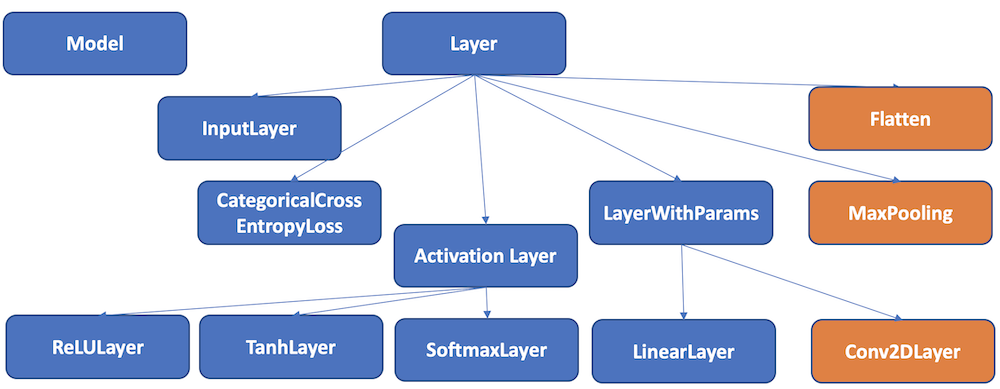
</div>

Here is a brief description of the new classes
- Conv2DLayer models the linear convolutional portion of a convolutional layer.  We have split the nonlinar activation function part (e.g. ReLu) into separate class like we did before for the fully-connect LinearLayer in Assignment 3. Specifically, given an input volume $x$ and a weight tensor $w$, and a set of biases $b$, this layer performs, $z=x*w+b$ where $*$ is the convolution operation, and $z$ is the resulting output volume.
- MaxPoolingLayer models a Max Pooling layer.
- FlattenLayer models the layer that connects the final convolutional layer to fully-connected layers. i.e. it flattens the final volume into a vector.

If you need to review what the other classes do, you can refer to Assignment 3. As with the previous assignment, the only parts you will need to implement are the forward_propagate() and backward_propagate() of the following classes:
- FlattenLayer
- MaxPoolingLayer
- Conv2DLayer

You can tackle the above classes in any order that you'd like. But the above order, in my opinion, goes from easiest to hardest. You will likely spend the majority of your time on the convolution backpropagation.

For each class, you will need to get forward propagate working first before backward propagate. The reason is that backward propagate should depend on some values computed during forward propagate. The framework is structured to cache some values during forward propagate to send to their corresponding backward propagate functions. Furthermore, the built in tests use numerical gradient checking which in turn uses the corresponding forward propgagation function.

The framework has been provided as a collection of Python .py files outside of this notebook.  The functions that you need to implement are set up as static functions inside this Jupyter notebook, and are then inserted into their respective classes. You don't need to understand this process. We just mention it in case you are curious.



## 1.1 Review of the Framework 

Most of this section is a recap of useful information from Assignment 3.

### 1.1.1 How this will all come together in the end

Recall that in the last assignment we could build arbitrarily deep fully-connected networks. By the end of this assignment, we will be able to build arbitrarily deep Convolutional Neural Networks. 

Here is an example of how we would specify a CNN architecture using our framework:

    nnmodel = Model([
        InputLayer((28, 28, 1)), # Input (28,28, 3) e.g. 28x28 color image 
        Conv2DLayer(3, (5, 5)),  # Conv K=3 f=5:     z1 = x * w1 + b1
        ReLULayer(),             # ReLU activation:  a1 = relu(z1) 
        MaxpoolLayer((2, 2)),    # MaxPooling (2,2): z2 = maxpool(a1)
        Conv2DLayer(2, (3, 3)),  # Conv K=2 f=3:     z3 = z2 * w2 + b2
        ReLULayer(),             # ReLU activation:  a3 = relu(z3)
        FlattenLayer(),          # flatten volume to vector
        LinearLayer(n_c),        # Fully Connected:  z4 = w3 a3 + b4
        SoftmaxLayer()])         # Softmax output:   a4 = softmax(z4)
 
    # Compile model using Categorical Cross Entropy Loss
    nnmodel.compile(loss=CategoricalCrossEntropyLoss())
    
    # Train for 200 gradient descent iterations using learning rate of 0.2
    nnmodel.train(X_train, Y_train, validation_data=(X_validation, Y_validation), epochs=200, learning_rate=0.2)

    # Use the model for prediction on some new data
    nnmodel.predict(X)
    

### 1.1.2 Caching values between forward_propagate() and backward_propagate()

During forward propagation, you may want to cache some values to be used during backward propagation.  We will let you decide which values to cache. The framework is designed so that forward_propagate() functions all initialize and return a cache object.  The cache object will be automatically passed to the corresponding backward propagate function via an input argument. This is all handled for you.  You just need to choose which objects to cache, and write the code to perform the actual caching.  See below for examples.

#### 1.1.2.1 Example of caching one object

For example, to save one numpy array stored in variable named x during linear_forward_propagate():

    def linear_forward_propagate(x, w, b):
        cache = None 

        ### START CODE HERE ###
        ...
        cache = x  # <-- This is what you write. Caching x
        
        ### END CODE HERE ###
        
        return z, cache 
        
The cache object in linear_forward_propagate() will automatically be passed to linear_backward_propagate(). To load load x during linear_backward_propagate():

    def linear_backward_propagate(dJ_dz, cache):
    
        ### START CODE HERE ###        
        ...
        x= cache # <-- This is what you write. Load cached object
        
        ### END CODE HERE ###        
        ...


#### 1.1.2.2 Example of caching more than one object

For example, to save three numpy arrays stored in variable named x,w,b during linear_forward_propagate(), cache the arrays as a single Python tuple

    def linear_forward_propagate(x, w, b):
        cache = None

        ### START CODE HERE ###
        ...
        cache = (x,w,b)  # <-- This is what you write. Caching x,w,b as a single tuple
        
        ### END CODE HERE ###
        
        return z, cache 
        
The cache object in linear_forward_propagate() will automatically be passed to linear_backward_propagate(). To load load x,w,b during linear_backward_propagate(), use Python tuple unpacking:

    def linear_backward_propagate(dJ_dz, cache):
    
        ### START CODE HERE ###        
        ...
        x, w, b = cache # <-- This is what you write. Load cached object and unpack
        
        ### END CODE HERE ###        
        ...

### 1.1.3 Compute Graph

Our framework does not explicitly model a compute graph. Specifically, we do not have separate classes and objects to model compute graph nodes, and connections.  You can think of there being an implicit compute graph described by the operations that you will implement in the forward_propagate() and backward_propagate() methods.  

You should, however, use the idea of a compute graph to help you map out the operations of each layer.  This may help you figure out what operations need to go into each layer's backward_propagate() methods.  


### 1.1.4 Tests

Each function that you will need to implement is followed by one or more test cells. You can run them manually like any other code cell.  Or you can use the "Validate" button on the Jupyter menu which will run all test cells. You can submit your assignment without passing all the tests. But this would mean that you would not get full marks.

**IMPORTANT NOTE**: The Validate button currently gives no user feedback and since some of the tests are slow, it may appear that your notebook is hung.  For now, I recommend running your tests manually.

### 1.1.5 Gradient Checking

The backward propagation tests in this assignment will make use of Gradient Checking (as discussed in lecture) instead of comparing to hardcoded values. In practice, when employing good software development practices such as test-driven development where you write your tests before implementation, it is difficult to write tests that contain the "correct" back-prop values to compare against. The reason is that this is very error prone, and time consuming because you will need to manually compute these values for each backpropagated value that you need.

Whereas with gradient checking, you can write a single generic function to compute an approximation to the numerical gradient of any function, and then simply check that the relative difference of this value is close enough to your backpropagation results.

Gradient checking is a real thing that people use when developing custom low-level backpropagation implementations.

The tests that use gradient checking will always print out error between the numeric gradient for your interest. So don't worry if you see those messages. As long as there are no assertion failures, the test has passed.

### 1.1.5 General Tips

- Don't worry about vectorized implementations for this assignment. Please use loops. The goal of this assignment is to familiarize you with the operations going on in the Convolution and MaxPooling layers. Although we covered some of the vectorized approaches in lecture, we feel that they will obscure the actual operations happening in these layers. 
- If you are having trouble, check the shapes of any intermediate matricies (e.g. local gradients) that you are computing. Getting the shapes right will solve a lot of problems
- Lectures 12, 13, 14 will be particularly useful.
- One possible approach to this assignment is to implement all the forward propagate functions first.  You don't even need to think about what values to cache at this point.  Then, as you start working on the backward propagate functions, you can update your forward propagate functions to cache values as needed.
- I think the easiest (to hardest) layers to complete in this assignment are Flatten, MaxPooling, Convolutional.  You can work on each layer independently and in any order.  
- I am sure Convolutional layer will take up the majority of your time, especially the back propagation.
    
Ok let's get started! Run the following code to import NumPy, Matplotlib, and the classes we have provided.

In [23]:
import numpy as np
import matplotlib.pyplot as plt

from categorical_loss import CategoricalCrossEntropyLoss
from conv_layer import Conv2DLayer
from input_layer import InputLayer
from flatten_layer import FlattenLayer
from linear_layer import LinearLayer
from maxpool_layer import MaxpoolLayer
from model import Model
from relu_layer import ReLULayer
from softmax_layer import SoftmaxLayer
from tanh_layer import TanhLayer

from a4_tools import rel_error, numeric_gradient

%matplotlib inline


## 1.2 Convolution Layer

In this section, you will implement the forward and backward propagate through a Convolutional Layer.

As discussed in class, the convolution operation plays a key role in both the forward and backward propagation through a Convolutional Layer. You will first implement a function to perform convolution between two 3D tensors.  You will then use this function to help you implement the forward and backward propagations through a Convolutional Layer.

### 1.2.1 Convolution Operation

Implement the following *convolve()* function which performs the convolution between two 3D Tensors and produces a 2D Tensor.  As discussed in class, in practice, convolution is transformed into matrix multiplcation for speed of computation.  Don't go down that route for this assignment! You do not need to write vectorized code. Furthermore, you do **NOT** need to consider convolution stride or padding.

**Hints**
- The most straightforward way for this step is to use 5 nested loops. Another way is to only use 2 loops and vectorize the rest.  Although not required, if you do the latter, Section 2's training code will run a fair bit faster. If you want to do this, think about how to vectorize the computation for each output value.
- Read the function description comment carefully. There are a lot of restrictions on how to use this function. Luckily, this shouldn't affect how you implement your portion of this function. But it will be important for when you use this function to implement your forward_propagate() and backward_propagate() functions.


In [70]:
# GRADED FUNCTION: convolve

def convolve(input, filter):
    """ Compute the convolution of 'input' with 'filter. 

    Inputs:
        input: A 2D or 3D NumPy array. e.g. (h, w) or (h, w, c) 
               In the context of conv layer forward propagation,  
               you can thinkof this as the input volume.
        filter: A 2D or 3D NumPy array. e.g. (h, w) or (h, w, c) 
                In the context of conv layer forward propagation, 
                you can think of this as one filter. 

        The following restrictions on 'input' and 'filter' will be important for
        when you go to use this function in your forward and backward propagate
        implementations:
          - Must have the same shape
          - Shapes must have either 2 or 3 dimensions
          - If 2 dimensions, then a third dimension will be added with size 1
          - If 3 dimensions, last dimension must be equal in size
          - First two dimensions of 'filter' must be equal (i.e. square)
          - First two dimensions of 'filter' must not be larger than 'input's

    Returns:
        output: A 2D NumPy array for the result of the convolution
    """

    # Check the various restrictions described in the function comments
    assert len(input.shape) == len(filter.shape), \
        'Input and filter must have equal number of dimensions'
    assert len(input.shape) in (2, 3), \
        'Input and filter must have either 2 or 3 dimensions'
    assert input.shape[0] >= filter.shape[0] and input.shape[1] >= filter.shape[1], \
        'filter spatial dimensions must not be greater than the inputs'

    # If 2 dimensions, extend to 3 dimensions (channels) where 3rd dimension is size 1
    if len(input.shape)==2 and len(filter.shape)==2:
        input = np.expand_dims(input, axis=-1)
        filter = np.expand_dims(filter, axis=-1)

    assert input.shape[-1] == filter.shape[-1], 'Input and filter must have equal number of channels'
    assert filter.shape[0] == filter.shape[1], "Only square filters supported"

    ### START CODE HERE (~10-12 lines of code) ###
    # YOUR CODE HERE
    
    #given input and filter
    #return the output
    row = input.shape[0] - filter.shape[1] + 1
    column = input.shape[1] - filter.shape[1] + 1
    output = np.zeros((row, column))

    for r in range(row):
        for c in range(column):
            conv_sum = 0
            for chanel_num in range(filter.shape[-1]):
                current_matrix = input[r:r + filter.shape[1], c:c+filter.shape[1], chanel_num]
                conv = np.multiply(current_matrix, filter[:, :, chanel_num])
                conv_sum += np.sum(conv)
                #
            output[r, c] = conv_sum
    ### END CODE HERE ###

    
    return output

In [74]:
def test_convolve():
    """ Testcase for convolve()

    1. Tests that output is a NumPy array
    2. Tests that output has correct shape
    3. Tests that output has correct values
    """
    h_in, w_in, c_in = (4,4,2)
    f = 3
    
    np.random.seed(0)
    x = np.random.randn(h_in, w_in, c_in)
    w = np.random.randn(f,f,c_in)
    
    z = convolve(x, w)

    z_expected = np.array([[-2.33439011, -4.01199384],
                           [ 3.028355  , -4.3936808 ]])

    assert isinstance(z, np.ndarray), 'Expected a Numpy array for output'
    assert z.shape == z_expected.shape, 'Unexpected shape for output. Expected {0} but got {1}'.format(
        z_expected.shape, z.shape)
    assert np.allclose(z, z_expected), 'Unexpected values for output: \n{0}'.format(z)

    print('PASSED: test_convolve()')


# Run the test
test_convolve()

PASSED: test_convolve()


### 1.2.2 Convolution Forward Propagation

Implement the conv_forward_propagate() function below to implement the linear portion of the forward propagation through a Convolutional Layer. Do not worry at all about vectorization here. Use loops. You do not need to consider stride nor do you need to consider padding.  i.e. assume stride=1 and no padding is used for this convolutional layer.

**Hints**
- Use the convolve() function that you implemeneted in the previous section! 
- Read the conovle() function description carefully to understand it's restrictions


In [75]:
# GRADED FUNCTION: conv_forward_propagate

@staticmethod
def conv_forward_propagate(x, w, b):
    """ Compute the forward propagation through the linear portion of a 
        convolution layer.  i.e. Compute z = x * w + b where '*' is the 
        convolution operation

    Inputs:
        x: A batch of input volumes to this layer. This is a NumPy array of shape
           (h_in, w_in, c_in, m) where h_in and w_in are the height and width
           spatial dimensions of the input volumes, c_in is the number of channels
           in each input volume, and m is the number of volumes (i.e. samples) in the batch
        w: Weights in this layer. This is a NumPy array of shape (K, f, f, c_in)
           where K is the number of filters, f is the spatial dimension of each
           square filter, and c_in is the number of channels of each filter.
        b: Biases in this layer. This is a NumPy array of shape (K, ) 
           where K is the number of filters.

    Returns:
        z: A batch of output volumes from this layer. This is a NumPy array of
           shape (h_out, w_out, c_out, m) where h_out and w_out are the height 
           and width spatial dimensions of the output volumes, c_out is the number 
           of channels in each output volume, and m is the number of volumes 
           (i.e. samples) in the batch
        cache: Objects to be sent to backpropagation for this layer.
    """
    cache = None

    ### START CODE HERE (~8 lines of code) ###
    # YOUR CODE HERE
    row = x.shape[0] - w.shape[1] + 1
    column = x.shape[1] - w.shape[1] + 1
    
    z = np.zeros((row, column, w.shape[0], x.shape[3]))
    #print(z.shape)
    for K in range(w.shape[0]):
        for m in range(x.shape[-1]): 
            conv = convolve(x[:, :, :, m], w[K, :, :, :]) + b[K, ]
            z[:, :, K, m] = conv
    
    cache = x, w, b
    
    ### END CODE HERE ###

    return z, cache


# Set the above function as the forward_propagate() function in the Conv2DLayer class
Conv2DLayer.forward_propagate = conv_forward_propagate

In [76]:
def test_conv_forward():
    """ Testcase for conv_forward_propagate() """


    # Setup object under test
    h_in = 3
    w_in = 3
    c_in = 2

    K = 2
    f = 2

    m = 3

    l = Conv2DLayer(K, (f, f))
    l.compile((h_in, w_in, c_in))

    # Input Data
    np.random.seed(0)
    x = np.random.randn(h_in, w_in, c_in, m)
    w = np.random.randn(K, f, f, c_in)
    b = np.random.randn(K,)

    # Forward Propagate
    z, _ = l.forward_propagate(x, w, b)
    z_expected = np.array([[[[-0.06808443,  2.2063421 ,  2.04546758],
                             [-7.44721213, -0.31350937,  4.27079924]],

                            [[ 0.265886  ,  1.49239275,  1.30114361],
                             [-5.3816754 ,  2.14376326, -0.71738463]]],

                           [[[ 1.72876052,  0.24659319,  1.75459078],
                             [-1.3961746 , -5.82303907,  3.38093613]],

                            [[ 2.18352133,  0.89027823,  2.41333406],
                             [ 3.4930211 , -4.72097211, -0.72331855]]]])

    # Test output
    assert isinstance(z, np.ndarray), 'Expected a Numpy array for z'
    assert z.shape == z_expected.shape, 'Unexpected shape for z. Expected {0} but got {1}'.format(z_expected.shape, z.shape)
    assert np.allclose(z, z_expected), 'Unexpected values for z: \n{0}'.format(z)

    print('PASSED: test_conv_forward()')


# Run the test
test_conv_forward()

PASSED: test_conv_forward()


### 1.2.3 Convolution Backward Propagation

Implement the conv_backward_propagate() function below to compute the backward propagation of the linear portion through a Convolutional Layer. Do not worry at all about vectorization here. Use loops. Use the convolve() function that you implemeneted in the previous section. You do not need to consider stride nor do you need to consider padding.  i.e. assume stride=1 and no padding is used for this convolutional layer.

**Hints**
- You may want to use the [np.pad()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html) function. For example, *np.pad(a, (1, 1), 'constant', constant_values=(0,0))* will pad the top, bottom, left, and right of the 2D array *a* with 1 row/column of 0's. Specifically, the second argument of (1,1) means to pad one row/column before, and one row/column after.  You will need to figure the appropriate number to use here.  The named argument *constant_values* specifies what value to pad with. In this example, we are padding with the number 0 before and after each dimension.
- You may want to use the [np.rot90()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.rot90.html) function. For example, *np.rot90(f, 3)* will rotate the 2D array *f* by 3*90=270 degrees (clockwise). 


In [77]:
# GRADED FUNCTION: conv_backward_propagate

@staticmethod
def conv_backward_propagate(dJ_dz, cache):
    """ Compute the back propagation through this layer. i.e. compute dJ_dx
        to propagate back to the previous layer as well as the parameter
        gradients dJ_dw, and dJ_db.  

    Inputs:
        dJ_dz: Upstream gradients on output volumes of this layer. This is a 
               NumPy array of shape (h_out, w_out, c_out, m) where h_out and 
               w_out are the height and width spatial dimensions of the output
               volumes, c_out is the number of output volume channels, and m 
               is the number of samples in the batch.
        cache: cached values saved during forward propagate

    Returns:
        dJ_dx: Gradients of the inputs volumes. This is a NumPy array of shape
               (h_in, w_in, c_in, m) where h_in and w_in are the height and width
               spatial dimensions of the input volumes, c_in is the number of 
               channels in each input volume, and m is the number of samples in 
               the batch
        dJ_dw: Gradients of the layer weights. This is a NumPy array of shape 
               (K, f, f, c_in) where K is the number of filters, f is the spatial 
               dimension of each filter, and c_in is the number of channels of 
               each filter.
        dJ_db: Gradients of the layer biases. This is a NumPy array of shape (K, ) 
               where K is the number of filters.
    """
    
    ### START CODE HERE (~13-20 lines of code) ###
    # YOUR CODE HERE
    x, w, b = cache
    
    dJ_dx = np.zeros(x.shape)
    dJ_dw = np.zeros(w.shape)
    dJ_db = np.zeros(b.shape)
 
    (row, col, K, M) = (dJ_dz.shape)
    
    for m in range (M):
        for r in range (row):
            for c in range (col):
                for k in range (K):
                    dJ_dx[r:r+w.shape[1], c:c+w.shape[1], :, m] += (w[k,:,:,:] * dJ_dz[r,c,k,m])
                    dJ_dw[k,:,:,:] += x[r:r+w.shape[1], c:c+w.shape[1],:,m] * dJ_dz[r,c,k,m]
                    dJ_db[k,] += dJ_dz[r, c, k, m]
    ### END CODE HERE ###

    return dJ_dx, dJ_dw, dJ_db


# Set the above function as the backward_propagate() function in the Conv2DLayer class
Conv2DLayer.backward_propagate = conv_backward_propagate

We have provided 8 separate tests for the back propagation which hopefully can help you debug your implementation. All 8 tests share common code to perform gradient check on dJ_dx, dJ_dw, and dJ_db.  Furthermore, they all test with the same input volume spatial dimensions h_in, and w_in, and filter size f.  

The difference is that each test varies the number of samples, number of filters, and number of input channels from either 1 or 2 (i.e. more than 1). The combinations are summarized in the following table.  

| Test Name | Number of Samples (m) | Number of Filters (K) | Number of input/filter channels (c_in) |
|-----------|-----------------------|-----------------------|----------------------------------------|
| test_conv_backward_0 | 1 | 1 | 1 |
| test_conv_backward_1 | 1 | 1 | 2 |
| test_conv_backward_2 | 1 | 2 | 1 |
| test_conv_backward_3 | 2 | 1 | 1 |
| test_conv_backward_4 | 1 | 2 | 2 |
| test_conv_backward_5 | 2 | 1 | 2 |
| test_conv_backward_6 | 2 | 2 | 1 |
| test_conv_backward_7 | 2 | 2 | 2 |

In [78]:
def test_conv_backward_common(c_in, K, m, test_name):
    """ Common test code for conv backward propagate """
    
    # Setup object under test
    h_in = 3
    w_in = 3
    f = 2

    l = Conv2DLayer(K, (f, f))
    l.compile((h_in, w_in, c_in))

    # Test that forward propagation works first
    forward_prop_works = True
    try:
        test_conv_forward()
    except:
        forward_prop_works = False
    assert forward_prop_works, """conv_forward_propagate() doesn't seem to work. 
            Make sure you implement forward propagation of this layer before 
            attempting backward propagation. """

    # Input Data
    np.random.seed(0)
    x = np.random.randn(h_in, w_in, c_in, m)
    w = np.random.randn(K, f, f, c_in)
    b = np.random.randn(K,)
    dJ_dz = np.random.randn((h_in-f+1), (w_in-f+1), K, m)

    # Forward Propagation
    z, cache = l.forward_propagate(x, w, b)

    # Backward Propagation
    dJ_dx, dJ_dw, dJ_db = l.backward_propagate(dJ_dz, cache)

    # Test are numpy arrays
    assert isinstance(dJ_dx, np.ndarray), 'Expected a Numpy array for dJ_dx'
    assert isinstance(dJ_dw, np.ndarray), 'Expected a Numpy array for dJ_dw'
    assert isinstance(dJ_db, np.ndarray), 'Expected a Numpy array for dJ_db'

    # Test gradient matrix shapes
    assert dJ_dx.shape == x.shape, "dJ_dx has the wrong shape. Expected {0}, but got {1}".format(x.shape, dJ_dx.shape)
    assert dJ_dw.shape == w.shape, "dJ_dw has the wrong shape. Expected {0}, but got {1}".format(w.shape, dJ_dw.shape)
    assert dJ_db.shape == b.shape, "dJ_db has the wrong shape. Expected {0}, but got {1}".format(b.shape, dJ_db.shape)

    # Check gradients
    dJ_dx_num = numeric_gradient(lambda x: Conv2DLayer.forward_propagate(x, w, b)[0], x, dJ_dz)
    dJ_dw_num = numeric_gradient(lambda w: Conv2DLayer.forward_propagate(x, w, b)[0], w, dJ_dz)
    dJ_db_num = numeric_gradient(lambda b: Conv2DLayer.forward_propagate(x, w, b)[0], b, dJ_dz)

    # Test error between numeric and anlytic gradient
    dJ_dx_error = rel_error(dJ_dx, dJ_dx_num)
    dJ_dw_error = rel_error(dJ_dw, dJ_dw_num)
    dJ_db_error = rel_error(dJ_db, dJ_db_num)

    print('Gradient Check Error for dJ_dx: {0}'.format(dJ_dx_error))
    print('Gradient Check Error for dJ_dw: {0}'.format(dJ_dw_error))
    print('Gradient Check Error for dJ_db: {0}'.format(dJ_db_error))

    assert rel_error(dJ_dx, dJ_dx_num) < 1e-8, 'Failed gradient check on dJ_dx'
    assert rel_error(dJ_dw, dJ_dw_num) < 1e-8, 'Failed gradient check on dJ_dw'
    assert rel_error(dJ_db, dJ_db_num) < 1e-8, 'Failed gradient check on dJ_db'

    print('PASSED: {0}()'.format(test_name))

In [79]:
def test_conv_backward_0():
    """ 1 sample, 1 filter, 1 channel """
    m    = 1
    K    = 1
    c_in = 1
    test_name = 'test_conv_backward_0'
    test_conv_backward_common(c_in, K, m, test_name)

test_conv_backward_0()

PASSED: test_conv_forward()
Gradient Check Error for dJ_dx: 1.2187203217024137e-10
Gradient Check Error for dJ_dw: 1.8163852553810774e-11
Gradient Check Error for dJ_db: 1.2537472269089095e-11
PASSED: test_conv_backward_0()


In [80]:
def test_conv_backward_1():
    """ 1 sample, 1 filter, 2 channel """
    m    = 1
    K    = 1
    c_in = 2
    test_name = 'test_conv_backward_1'
    test_conv_backward_common(c_in, K, m, test_name)

test_conv_backward_1()

PASSED: test_conv_forward()
Gradient Check Error for dJ_dx: 1.5388170649026211e-09
Gradient Check Error for dJ_dw: 9.216560934616588e-11
Gradient Check Error for dJ_db: 1.883494110228754e-11
PASSED: test_conv_backward_1()


In [81]:
def test_conv_backward_2():
    """ 1 sample, 2 filter, 1 channel """
    m    = 1
    K    = 2
    c_in = 1
    test_name = 'test_conv_backward_2'
    test_conv_backward_common(c_in, K, m, test_name)

test_conv_backward_2()

PASSED: test_conv_forward()
Gradient Check Error for dJ_dx: 7.415191206968242e-11
Gradient Check Error for dJ_dw: 5.843820581518397e-11
Gradient Check Error for dJ_db: 9.237840536979514e-12
PASSED: test_conv_backward_2()


In [82]:
def test_conv_backward_3():
    """ 2 sample, 1 filter, 1 channel """
    m    = 2
    K    = 1
    c_in = 1
    test_name = 'test_conv_backward_3'
    test_conv_backward_common(c_in, K, m, test_name)

test_conv_backward_3()

PASSED: test_conv_forward()
Gradient Check Error for dJ_dx: 9.741428737094036e-11
Gradient Check Error for dJ_dw: 6.09468136953806e-11
Gradient Check Error for dJ_db: 6.8264926166949065e-12
PASSED: test_conv_backward_3()


In [83]:
def test_conv_backward_4():
    """ 1 sample, 2 filter, 2 channel """
    m    = 1
    K    = 2
    c_in = 2
    test_name = 'test_conv_backward_4'
    test_conv_backward_common(c_in, K, m, test_name)

test_conv_backward_4()

PASSED: test_conv_forward()
Gradient Check Error for dJ_dx: 9.084732482401095e-11
Gradient Check Error for dJ_dw: 2.4229898974491935e-10
Gradient Check Error for dJ_db: 8.534828869135842e-12
PASSED: test_conv_backward_4()


In [84]:
def test_conv_backward_5():
    """ 2 sample, 1 filter, 2 channel """
    m    = 2
    K    = 1
    c_in = 2
    test_name = 'test_conv_backward_5'
    test_conv_backward_common(c_in, K, m, test_name)

test_conv_backward_5()

PASSED: test_conv_forward()
Gradient Check Error for dJ_dx: 1.341682047104462e-10
Gradient Check Error for dJ_dw: 6.442858708277674e-11
Gradient Check Error for dJ_db: 9.72170658297128e-12
PASSED: test_conv_backward_5()


In [85]:
def test_conv_backward_6():
    """ 2 sample, 2 filter, 1 channel """
    m    = 2
    K    = 2
    c_in = 1
    test_name = 'test_conv_backward_6'
    test_conv_backward_common(c_in, K, m, test_name)

test_conv_backward_6()

PASSED: test_conv_forward()
Gradient Check Error for dJ_dx: 8.710910842020518e-11
Gradient Check Error for dJ_dw: 1.352627830952911e-10
Gradient Check Error for dJ_db: 2.2538998592530002e-10
PASSED: test_conv_backward_6()


In [86]:
def test_conv_backward_7():
    """ 2 sample, 2 filter, 2 channel """
    m    = 2
    K    = 2
    c_in = 2
    test_name = 'test_conv_backward_7'
    test_conv_backward_common(c_in, K, m, test_name)

test_conv_backward_7()

PASSED: test_conv_forward()
Gradient Check Error for dJ_dx: 2.2854678413554622e-10
Gradient Check Error for dJ_dw: 1.6985370952276815e-10
Gradient Check Error for dJ_db: 1.1072592664179245e-11
PASSED: test_conv_backward_7()


## 1.3 Max Pooling Layer

In this section, you will implement the forward and backward propagate through a MaxPooling Layer. You can assume that the stride is equal to the pooling region size.


**Hints**
- You may want to use the [np.max](https://docs.scipy.org/doc/numpy/reference/generated/numpy.amax.html) to get the maximum value in an array.
- You may want to use the [np.argmax](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html) function to get the index of the maximum value in an array. Note that the value returned corresponds to a flattend version of the array. E.g. consider a (3,4) array, if the max value is at [2,3], then the returned value is 11s.
- You may want to use the [np.unravel_index()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.unravel_index.html) function. This function converts a flat index into a tuple of coordinate indices.  For example, *np.unravel_index(11, (3,4))* will return *(2,3)*.  
- If you get the error *'float' object cannot be interpreted as an integer*, it means that some function you are calling is expecting an integer input but received a float. If this is the result of a float computation that you did, just cast the result back to an integer using *int()*


### 1.3.1 Max Pooling Forward Propagate

Implement the maxpool_forward_propagate() function below to compute the forward propagation through a MaxPooling layer.  Do not worry at all about vectorization here. Use loops. 


In [87]:
# GRADED FUNCTION: maxpool_forward_propagate

@staticmethod
def maxpool_forward_propagate(x, pool_size):
    """ Compute the forward propagation through a Max Pooling layer 
        i.e. Compute z = max_pool(x, pool_size) where max_pool() computes the 
        maximum value at each non-overlapping (i.e. stride is equal to 
        pool_size) pool_size region in x.

    Inputs:
        x: A batch of input volumes to this layer. This is a NumPy array of shape
           (h_in, w_in, c_in, m) where h_in and w_in are the height and width
           spatial dimensions of the input volumes, c_in is the number of channels
           in each input volume, and m is the number of samples in the batch
        pool_size: A Python 2-tuple denoting the pooling region size. E.g. (2,3) 
                   means to pool 2x3 regions

    Returns:
        z: A batch of output volumes from this layer. This is a NumPy array of
           shape (h_out, w_out, c_out, m) where h_out and w_out are the height 
           and width spatial dimensions of the output volumes, c_out is the number 
           of channels in each output volume, and m is the number of samples in the batch.
        cache: Objects to be sent to backpropagation for this layer.
    """
    cache = None

    ### START CODE HERE (~14 lines of code) ###
    # YOUR CODE HERE
    f = pool_size[0]
    
    #get shapes of input
    h_in, w_in, K, M = x.shape[0], x.shape[1], x.shape[2], x.shape[3]
    
    max_args = []
    
    w_new = int((w_in - f)/f + 1)
    h_new = int((h_in - f)/f + 1)
    
    z = np.zeros((w_new, h_new, K, M))
    #dz_dx = np.zeros(x.shape)
                    
    for m in range (M):
        for h in range (h_new):
            for w in range (w_new):
                for k in range (K):
                    z[h,w,k,m] = np.max(x[h*f:h*f+f, w*f:w*f+f, k, m])
                    #print(z)
                    max_args.append(np.argmax(x[h*f:h*f+f, w*f:w*f+f, k, m]))
                    #print(max_args) -> max arg of tensor?
                    #dz_dx[h*f:h*f+f, w*f:w*f+f, k, m].flat[int(np.argmax(x[h*f:h*f+f, w*f:w*f+f, k, m]))] = z[h,w,k,m]
    
    cache = x, pool_size #, max_args, z, dz_dx
    
    #print(max_args)
    #print(dz_dx)
    #print("----")
    #print(z)
    #print(dz_dx.shape) #(4, 4, 3, 2)
    ### END CODE HERE ###

    return z, cache


# Set the above function as the forward_propagate() function in the MaxpoolLayer class
MaxpoolLayer.forward_propagate = maxpool_forward_propagate

In [88]:
def test_maxpool_forward():
    """ Test for maxpool_forward_propagate() """
    # Setup object under test
    h_in = 4
    w_in = 4
    c_in = 3
    pool_size = (2,2)
    m = 2

    l = MaxpoolLayer(pool_size)
    l.compile((h_in, w_in, c_in))

    # Input Data
    np.random.seed(0)
    x = np.random.randn(h_in, w_in, c_in, m)

    # Forward Propagate
    z, _ = l.forward_propagate(x, pool_size)
    z_expected = np.array([[[[ 2.26975462,  0.40015721],
                             [ 0.97873798,  2.2408932 ],
                             [ 1.86755799,  1.46935877]],

                            [[ 1.23029068,  1.9507754 ],
                             [ 0.44386323,  0.6536186 ],
                             [ 1.49407907,  0.77749036]]],


                           [[[ 1.13940068,  0.42833187],
                             [ 0.40234164,  0.90082649],
                             [ 0.46566244, -0.36274117]],

                            [[ 1.48825219,  1.89588918],
                             [ 1.17877957,  0.97663904],
                             [ 0.72909056,  1.05445173]]]])

    # Test output
    assert isinstance(z, np.ndarray), 'Expected a Numpy array for z'
    assert z.shape == z_expected.shape, 'Unexpected shape for z. Expected {0} but got {1}'.format(z_expected.shape, z.shape)
    assert np.allclose(z, z_expected), 'Unexpected values for z: \n{0}'.format(z)

    print('PASSED: test_maxpool_forward()')

# Run the test
test_maxpool_forward()

PASSED: test_maxpool_forward()


### 1.3.2 Max Pooling Backward Propagate

Implement the maxpool_backward_propagate() function below to compute the backward propagation through a MaxPooling layer.  Do not worry at all about vectorization here. Use loops. 


In [89]:
# GRADED FUNCTION: maxpool_backward_propagate

@staticmethod
def maxpool_backward_propagate(dJ_dz, cache):
    """ Compute the back propagation through this layer. i.e. compute dJ_dx
        to propagate back to the previous layer.

    Inputs:
        dJ_dz: Upstream gradients on output volumes of this layer. This is a 
               NumPy array of shape (h_out, w_out, c_out, m) where h_out and 
               w_out are the height and width spatial dimensions of the output
               volumes, c_out is the number of output volume channels, and m 
               is the number of samples in the batch.
        cache: cached values saved during forward propagate

    Returns:
        dJ_dx: Gradients of the inputs volumes. This is a NumPy array of shape
               (h_in, w_in, c_in, m) where h_in and w_in are the height and width
               spatial dimensions of the input volumes, c_in is the number of 
               channels in each input volume, and m is the number of samples in 
               the batch
    """
    ### START CODE HERE (~10 lines of code) ###
    # YOUR CODE HERE
    #This simply means that the gradient to the neuron is 1 for the neuron with the maximum value. 
    #The gradients for all the other neurons are 0. 
    #The neurons whose gradients are 0 do not contribute to the gradients in the earlier neurons due to the chain rule.
    
    
    #cache = x, pool_size, max_args, z
    x, pool_size = cache
    f = pool_size[0]
    
    (H, W, K, M) = dJ_dz.shape
    dJ_dx = np.zeros(x.shape)
    
    for m in range (M):
        for h in range (H):
            for w in range (W):
                for k in range (K):
                    current_mat = x[h*f:h*f+f, w*f:w*f+f, k, m]
                    bool_mat = (current_mat == np.max(current_mat))
                    dJ_dx[h*f:h*f+f, w*f:w*f+f, k , m] = bool_mat.astype(int) * dJ_dz[h,w,k,m]
                    
                    
    ### END CODE HERE ###
    
    return dJ_dx


# Set the above function as the backward_propagate() function in the MaxpoolLayer class
MaxpoolLayer.backward_propagate = maxpool_backward_propagate

In [90]:
def test_maxpool_backward():

    # Setup object under test
    h_in = 4
    w_in = 4
    c_in = 3
    pool_size = (2,2)
    m = 2

    l = MaxpoolLayer(pool_size)
    l.compile((h_in, w_in, c_in))

    # Test that forward propagation works first
    forward_prop_works = True
    try:
        test_maxpool_forward()
    except:
        forward_prop_works = False
    assert forward_prop_works, """maxpool_forward_propagate() doesn't seem to work. 
            Make sure you implement forward propagation of this layer before 
            attempting backward propagation. """

    # Input Data
    np.random.seed(0)
    x = np.random.randn(h_in, w_in, c_in, m)
    dJ_dz = np.random.randn(int(h_in/pool_size[0]), int(w_in/pool_size[0]), c_in, m)

    # Forward Propagation
    z, cache = l.forward_propagate(x, pool_size)

    # Backward Propagation
    dJ_dx = l.backward_propagate(dJ_dz, cache)

    # Test are numpy arrays
    assert isinstance(dJ_dx, np.ndarray), 'Expected a Numpy array for dJ_dx'

    # Test gradient matrix shapes
    assert dJ_dx.shape == x.shape, "dJ_dx has the wrong shape. Expected {0}, but got {1}".format(x.shape, dJ_dx.shape)

    # Test error between numeric and anlytic gradient
    dJ_dx_num = numeric_gradient(lambda x: MaxpoolLayer.forward_propagate(x, pool_size)[0], x, dJ_dz)
    dJ_dx_error = rel_error(dJ_dx, dJ_dx_num)
    print('Gradient Check Error for dJ_dx: {0}'.format(dJ_dx_error))
    assert rel_error(dJ_dx, dJ_dx_num) < 1e-8, 'Failed gradient check on dJ_dx'

    print('PASSED: test_maxpool_backward()')


# Run the test
test_maxpool_backward()

PASSED: test_maxpool_forward()
Gradient Check Error for dJ_dx: 6.551269098031127e-12
PASSED: test_maxpool_backward()


## 1.4 Flatten Layer

This layer simply flattens an input volume into a vector. 

### 1.4.1 Flatten Forward Propagate

Implement the flatten_forward_propagate() function below to compute the forward propagation through a Flatten layer.

**Hints**
- Recall the [np.reshape()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html) function can be used to change the shape of a NumPy array. This is a very common NumPy function and worth becoming familiar with.

In [91]:
# GRADED FUNCTION: flatten_forward_propagate

@staticmethod
def flatten_forward_propagate(x):
    """ Compute the forward propagation through a Flatten Layer
        i.e. Compute z = flatten(x)

    Inputs:
        x: A batch of input volumes to this layer. This is a NumPy array of shape
           (h_in, w_in, c_in, m) where h_in and w_in are the height and width
           spatial dimensions of the input volumes, c_in is the number of channels
           in each input volume, and m is the number of samples in the batch

    Returns:
        z: A batch of output vectors from this layer. This is a NumPy array of
           shape (n, m) where n is the length of one flattened volume, and m is the 
           number of samples in the batch.
        cache: Objects to be sent to backpropagation for this layer.
    """
    cache = None

    ### START CODE HERE (~2 lines of code) ###
    # YOUR CODE HERE
    
    #print(x.shape) #4d tensor
   
    #shape should be (hin * win * cin)-> rows x m col
    #z = np.ndarray.flatten(x) -> not this, this autoflattens to single 1d tensor
    #length of flattened volume x num samples in batch
    
    z = np.reshape(x, (x.shape[0] * x.shape[1] * x.shape[2], x.shape[3])) 
    cache = x
    ### END CODE HERE ###

    return z, cache


# Set the above function as the forward_propagate() function in the FlattenLayer class
FlattenLayer.forward_propagate = flatten_forward_propagate

In [92]:
def test_flatten_forward():

    # Setup object under test
    h_in = 3
    w_in = 3
    c_in = 2
    m = 4
    l = FlattenLayer()
    l.compile((h_in, w_in, c_in))

    # Input Data
    np.random.seed(0)
    x = np.random.randn(h_in, w_in, c_in, m)

    # Forward propagate
    z, _ = l.forward_propagate(x)
    z_expected = np.array([[ 1.76405235,  0.40015721,  0.97873798,  2.2408932 ],
                           [ 1.86755799, -0.97727788,  0.95008842, -0.15135721],
                           [-0.10321885,  0.4105985 ,  0.14404357,  1.45427351],
                           [ 0.76103773,  0.12167502,  0.44386323,  0.33367433],
                           [ 1.49407907, -0.20515826,  0.3130677 , -0.85409574],
                           [-2.55298982,  0.6536186 ,  0.8644362 , -0.74216502],
                           [ 2.26975462, -1.45436567,  0.04575852, -0.18718385],
                           [ 1.53277921,  1.46935877,  0.15494743,  0.37816252],
                           [-0.88778575, -1.98079647, -0.34791215,  0.15634897],
                           [ 1.23029068,  1.20237985, -0.38732682, -0.30230275],
                           [-1.04855297, -1.42001794, -1.70627019,  1.9507754 ],
                           [-0.50965218, -0.4380743 , -1.25279536,  0.77749036],
                           [-1.61389785, -0.21274028, -0.89546656,  0.3869025 ],
                           [-0.51080514, -1.18063218, -0.02818223,  0.42833187],
                           [ 0.06651722,  0.3024719 , -0.63432209, -0.36274117],
                           [-0.67246045, -0.35955316, -0.81314628, -1.7262826 ],
                           [ 0.17742614, -0.40178094, -1.63019835,  0.46278226],
                           [-0.90729836,  0.0519454 ,  0.72909056,  0.12898291]])

    # Test output
    assert isinstance(z, np.ndarray), 'Expected a Numpy array for z'
    assert z.shape == z_expected.shape, 'Unexpected shape for z. Expected {0} but got {1}'.format(z_expected.shape, z.shape)
    assert np.allclose(z, z_expected), 'Unexpected values for z: \n{0}'.format(z)

    print('PASSED: test_flatten_forward()')


# Run the test
test_flatten_forward()

PASSED: test_flatten_forward()


### 1.4.2 Flatten Backward Propagate

Implement the flatten_backward_propagate() function below to compute the backward propagation through a Flatten layer.

**Hints**
- We didn't talk about backpropagation through this layer in lecture.  But based on your understanding of backpropagation, you should be able to figure it out. It is very simple so don't overthink it.


In [93]:
# GRADED FUNCTION: flatten_backward_propagate

@staticmethod
def flatten_backward_propagate(dJ_df, cache):
    """ Compute the back propagation through this layer. i.e. compute dJ_dx
        to propagate back to the previous layer.

    Inputs:
        dJ_dz: Upstream gradients on output volumes of this layer. This is 
               a NumPy array of shape (n, m) where n is the length of one 
               flattened volume, and m is the number of samples in the batch.
        cache: cached values saved during forward propagate

    Returns:
        dJ_dx: Gradients of the inputs volumes. This is a NumPy array of shape
               (h_in, w_in, c_in, m) where h_in and w_in are the height and width
               spatial dimensions of the input volumes, c_in is the number of 
               channels in each input volume, and m is the number of samples in 
               the batch
    """
    ### START CODE HERE (~2 lines of code) ###
    # YOUR CODE HERE
    
    x = cache
    #we want x.shape output shape
    #print(dJ_df.shape)
    
    #gradient calculation -> backprop through flatten layer is just the upstream gradient
    #this is because flattenin layer just reshapes data; doesn't change activations themselves
    #no backprop handling other than changing shape, just repropagate upstream gradient
    
    dJ_x = dJ_df
    
    #reshape to h_in, w_in, c_in, m
    dJ_x = np.reshape(dJ_x, (x.shape[0],x.shape[1],x.shape[2],x.shape[3]))
    
    ### END CODE HERE ###

    return dJ_x
    
    
# Set the above function as the backward_propagate() function in the FlattenLayer class
FlattenLayer.backward_propagate = flatten_backward_propagate

In [94]:
def test_flatten_backward():
    
    # Setup object under test
    h_in = 3
    w_in = 3
    c_in = 2
    m = 4

    l = FlattenLayer()
    l.compile((h_in, w_in, c_in))

    # Test that forward propagation works first
    forward_prop_works = True
    try:
        test_flatten_forward()
    except:
        forward_prop_works = False
    assert forward_prop_works, """flatten_forward_propagate() doesn't seem to work. 
            Make sure you implement forward propagation of this layer before 
            attempting backward propagation. """

    # Input Data
    np.random.seed(0)
    x = np.random.randn(h_in, w_in, c_in, m)
    dJ_dz = np.random.randn(h_in*w_in*c_in, m)

    # Forward Propagation
    z, cache = l.forward_propagate(x)

    # Backward Propagation
    dJ_dx = l.backward_propagate(dJ_dz, cache)

    # Test are numpy arrays
    assert isinstance(dJ_dx, np.ndarray), 'Expected a Numpy array for dJ_dx'

    # Test gradient matrix shapes
    assert dJ_dx.shape == x.shape, "dJ_dx has the wrong shape. Expected {0}, but got {1}".format(x.shape, dJ_dx.shape)

    # Check gradients
    dJ_dx_num = numeric_gradient(lambda x: FlattenLayer.forward_propagate(x.copy())[0], x, dJ_dz)

    # Test error between numeric and anlytic gradient
    dJ_dx_error = rel_error(dJ_dx, dJ_dx_num)
    print('Gradient Check Error for dJ_dx: {0}'.format(dJ_dx_error))
    assert rel_error(dJ_dx, dJ_dx_num) < 1e-8, 'Failed gradient check on dJ_dx'

    print('PASSED: conv_backward_test()')

    
# Run the test
test_flatten_backward()

PASSED: test_flatten_forward()
Gradient Check Error for dJ_dx: 6.551289381551274e-12
PASSED: conv_backward_test()


# 2. Training A Convolutional Neural Network Using Our Framework

Now that all the new layers are implemented, we can use them to construct some convolutional neural networks!  

We will again start by working with the MNIST dataset of handwritten digits.  

- 28x28 greyscale images
- 50,000 training images and 10,000 validation images
- 10 output classes (one for each digit)

Some examples from this data set:

<div>
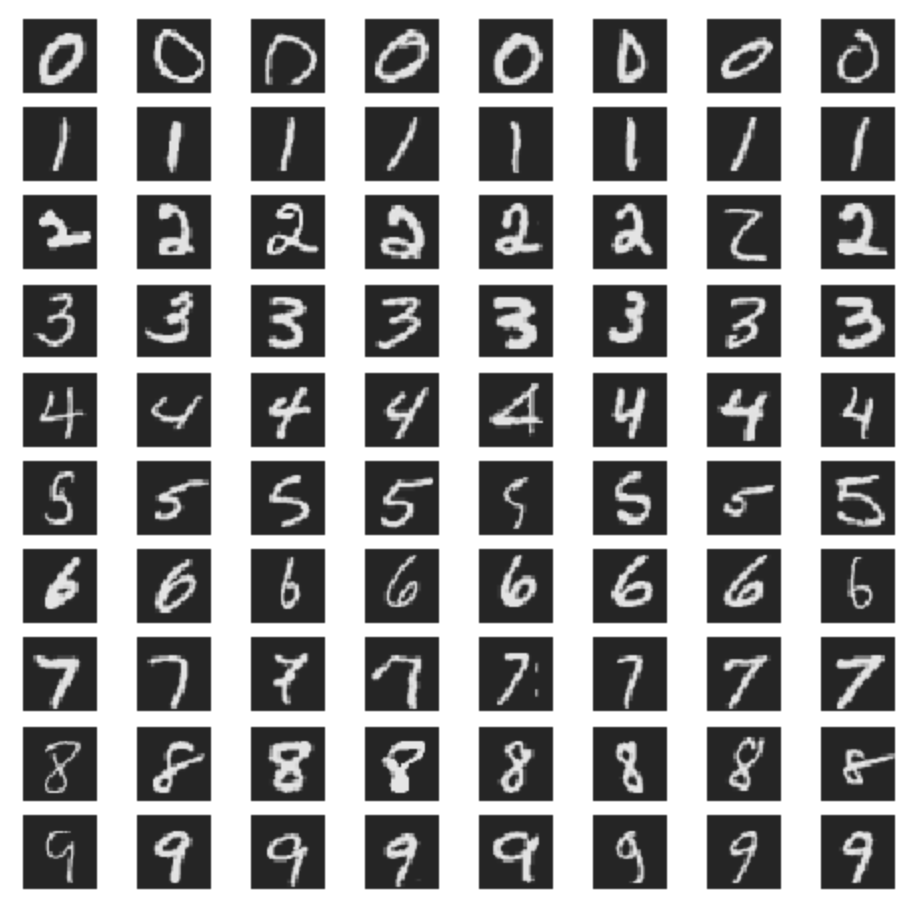
</div>


## 2.1. Single Conv Layer CNN

In this section, we will build the simplest possible CNN which consists of a single convolutional layer, followed by a relu layer, followed by a flatten layer, followed by fully-connected softmax layer.  

Since we did not focus on vectorization or compute efficiency at all, we actually can't train on the entire data set within any reasonable amount of time. As a demonstration that our framework works, we will train on a very small subset of 8 images from the training set.  We also only use 8 images from the validation set for validation. As you should expect, the train model will not generalize well to the validation data.

You should see the model train to 100% training accuracy, but only 62.% validation accuracy.  We will then also use the model to make a prediction on the 8 training and validation samples.  We will look at the raw softmax outputs, and the final predicted class compared to the true labels.

The take-away is that the model, and your implementations, work! This is actually a common approach for deep learning in practice.  You should first overfit your model with a very small training set (but 8 samples is too small even for that purpose).  This lets you quickly test that your training flow works.

Run the following code cell now.

X (training)   shape: (28, 28, 1, 60000)
Y (training)   shape: (60000,)
X (validation) shape: (28, 28, 1, 10000)
Y (validation) shape: (10000,)

0 loss: 2.29199571 - accuracy: 0.250 - val_loss: 2.29123057 - val_accuracy: 0.250
1 loss: 2.27847187 - accuracy: 0.500 - val_loss: 2.28195821 - val_accuracy: 0.500
2 loss: 2.25875171 - accuracy: 0.500 - val_loss: 2.26899698 - val_accuracy: 0.250
3 loss: 2.22579068 - accuracy: 0.375 - val_loss: 2.24904325 - val_accuracy: 0.250
4 loss: 2.16927160 - accuracy: 0.250 - val_loss: 2.21824383 - val_accuracy: 0.250
5 loss: 2.07586708 - accuracy: 0.250 - val_loss: 2.17340264 - val_accuracy: 0.250
6 loss: 1.93558691 - accuracy: 0.250 - val_loss: 2.11564049 - val_accuracy: 0.250
7 loss: 1.74910959 - accuracy: 0.375 - val_loss: 2.05132756 - val_accuracy: 0.250
8 loss: 1.51281381 - accuracy: 0.625 - val_loss: 1.97524504 - val_accuracy: 0.375
9 loss: 1.21841176 - accuracy: 0.875 - val_loss: 1.87002682 - val_accuracy: 0.500
10 loss: 0.88526990 - accuracy: 1.0

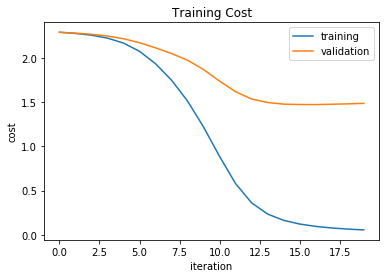

The 8 Training Samples
Raw Prediction (i.e. softmax output)
[[0.009 0.965 0.003 0.003 0.004 0.009 0.001 0.007]
 [0.017 0.000 0.002 0.952 0.037 0.010 0.944 0.011]
 [0.007 0.010 0.007 0.016 0.011 0.945 0.004 0.011]
 [0.026 0.010 0.012 0.014 0.008 0.014 0.005 0.938]
 [0.001 0.002 0.965 0.002 0.004 0.004 0.002 0.004]
 [0.938 0.009 0.001 0.004 0.002 0.005 0.017 0.023]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.002 0.003 0.010 0.009 0.933 0.013 0.026 0.007]]
Class Predictions
[5 0 4 1 9 2 1 3]
True Labels
[5 0 4 1 9 2 1 3]

The 8 Validation Samples
Raw Prediction (i.e. softmax output)
[[0.100 0.099 0.013 0.858 0.039 0.003 0.010 0.010]
 [0.074 0.621 0.844 0.002 0.018 0.934 0.054 0.123]
 [0.090 0.106 0.029 0.061 0.089 0.013 0.017 0.195]
 [0.224 0.052 0.021 0.012 0.085 0.009 0.130 0.023]
 [0.052 0.012 0.008 0.006 0.551 0.002 0.102 0.057]
 [0.208 0.070 0.034 0.034 0.021 0.010 0.023 0

In [95]:
from a4_tools import load_mnist, load_cifar10, one_hot, plot_sample, plot_costs
from a3_solutions import load_a3_solutions
load_a3_solutions()


def small_cnn_on_mnist():
    X_train, Y_train, X_validation, Y_validation = load_mnist()
    
    # Only use the first 8 samples of training set
    m = 8
    X_train = X_train[...,:m]
    Y_train = Y_train[...,:m]
    X_validation = X_validation[...,:m]
    Y_validation = Y_validation[...,:m]

    # Specify 10 output classes
    n_c = 10

    # Specify the model
    nnmodel = Model([
        InputLayer((28, 28, 1)), # (28,28,1) input volume 
        Conv2DLayer(6, (5, 5)),  # Conv layer with 6 (5,5) filters
        ReLULayer(),             # ReLU activation
        FlattenLayer(),          # Flatten volume
        LinearLayer(n_c),        # 10 unit fully connected output layer
        SoftmaxLayer()])         # softmax activation

    # Use Categorical Cross Entropy and compile compute graph
    nnmodel.compile(loss=CategoricalCrossEntropyLoss())

    # Train using Mini Batch Gradient Descent
    costs_train, costs_valid = nnmodel.train_sgd(X_train, 
                                    one_hot(Y_train, n_c),
                                    validation_data=(X_validation, one_hot(Y_validation, n_c)),
                                    epochs=20,          # Training Epochs
                                    learning_rate=0.05, # Learning Rate
                                    batch_size=128,     # Mini-Batch Gradient Descent batch size
                                    print_freq=1)       # Number of iterations between printing progress

    
    plot_costs(costs_train, costs_valid)
    
    np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

    predictions, raw_predictions = nnmodel.predict(X_train)

    print('The 8 Training Samples')
    print('Raw Prediction (i.e. softmax output)')
    print(raw_predictions)
    print('Class Predictions')
    print(predictions)
    print('True Labels')
    print(Y_train)

    
    predictions, raw_predictions = nnmodel.predict(X_validation)

    print()
    print('The 8 Validation Samples')
    print('Raw Prediction (i.e. softmax output)')
    print(raw_predictions)
    print('Class Predictions')
    print(predictions)
    print('True Labels')
    print(Y_validation)

    
small_cnn_on_mnist()

## 2.2. Two Conv Layers and MaxPooling CNN

Let's build a slightly deeper model with two Conv layers, and also use a MaxPooling layer in between.  

- Conv layer with 3 (3,3) filters
- MaxPool layer with (2,2) pooling regions
- Conv layer with 3 (3,3) filters

Don't read too much into the architectural hyperparameter choices in this example. We had to keep things small due to our framework's lack of compute efficiency.  After this, we will move to Keras and be able to do more realistic experiments.

The following example follows a similar process as before except we have a different architecture, and we use an even smaller training and validation set size of only 4 samples. This is unrealistic but we just want to test that our layers work within the constraints of our available compute resources.

Run the following cell to train the model.

X (training)   shape: (28, 28, 1, 60000)
Y (training)   shape: (60000,)
X (validation) shape: (28, 28, 1, 10000)
Y (validation) shape: (10000,)

0 loss: 2.28617103 - accuracy: 0.250 - val_loss: 2.30157460 - val_accuracy: 0.000
1 loss: 2.26996227 - accuracy: 0.250 - val_loss: 2.29967470 - val_accuracy: 0.000
2 loss: 2.25253649 - accuracy: 0.250 - val_loss: 2.29804603 - val_accuracy: 0.000
3 loss: 2.23243207 - accuracy: 0.250 - val_loss: 2.29664360 - val_accuracy: 0.000
4 loss: 2.20691290 - accuracy: 0.250 - val_loss: 2.29541531 - val_accuracy: 0.000
5 loss: 2.17102179 - accuracy: 0.250 - val_loss: 2.29442513 - val_accuracy: 0.000
6 loss: 2.11642485 - accuracy: 0.250 - val_loss: 2.29444327 - val_accuracy: 0.000
7 loss: 2.03127908 - accuracy: 0.250 - val_loss: 2.29911125 - val_accuracy: 0.000
8 loss: 1.90529189 - accuracy: 0.250 - val_loss: 2.32110171 - val_accuracy: 0.000
9 loss: 1.74616452 - accuracy: 0.250 - val_loss: 2.39209182 - val_accuracy: 0.000
10 loss: 1.59528227 - accuracy: 0.2

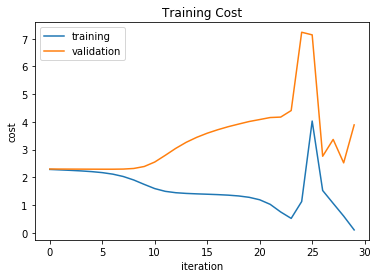

The 4 Training Samples
Raw Prediction (i.e. softmax output)
[[0.000 0.690 0.000 0.000]
 [0.025 0.076 0.004 0.991]
 [0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000]
 [0.004 0.097 0.993 0.002]
 [0.970 0.135 0.001 0.006]
 [0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000]]
Class Predictions
[5 0 4 1]
True Labels
[5 0 4 1]

The 4 Validation Samples
Raw Prediction (i.e. softmax output)
[[0.012 0.004 0.003 0.182]
 [0.142 0.485 0.783 0.050]
 [0.003 0.000 0.005 0.000]
 [0.004 0.000 0.006 0.000]
 [0.215 0.024 0.020 0.230]
 [0.609 0.485 0.159 0.536]
 [0.004 0.000 0.006 0.000]
 [0.004 0.000 0.006 0.000]
 [0.004 0.000 0.006 0.000]
 [0.004 0.000 0.005 0.000]]
Class Predictions
[5 5 1 5]
True Labels
[7 2 1 0]


In [96]:
def two_layer_cnn_on_mnist():

    X_train, Y_train, X_validation, Y_validation = load_mnist()
    
    # Only use the first 4 samples of training set
    m = 4
    X_train = X_train[...,:m]
    Y_train = Y_train[...,:m]
    X_validation = X_validation[...,:m]
    Y_validation = Y_validation[...,:m]

    # Specify 10 output classes
    n_c = 10
    
    # Specify the model
    nnmodel = Model([
        InputLayer((28, 28, 1)), # (28,28,1) input volume 
        Conv2DLayer(3, (3, 3)),  # Conv layer with 6 (5,5) filters
        ReLULayer(),             # ReLU activation
        MaxpoolLayer((2, 2)),    # MaxPooling (2,2)
        Conv2DLayer(2, (3, 3)),  
        ReLULayer(),             # ReLU activation
        FlattenLayer(),
        LinearLayer(n_c),        # 10 unit fully connected output layer
        SoftmaxLayer()])         # softmax activation

    # Use Categorical Cross Entropy and compile compute graph
    nnmodel.compile(loss=CategoricalCrossEntropyLoss())

    # Train using Mini Batch Gradient Descent
    costs_train, costs_valid = nnmodel.train_sgd(X_train, 
                                    one_hot(Y_train, n_c),
                                    validation_data=(X_validation, one_hot(Y_validation, n_c)),
                                    epochs=30,         # Training Epochs
                                    learning_rate=0.1,# Learning Rate
                                    batch_size=128,    # Mini-Batch Gradient Descent batch size
                                    print_freq=1)      # Number of iterations between printing progress

    plot_costs(costs_train, costs_valid)
    
    np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

    predictions, raw_predictions = nnmodel.predict(X_train)

    print('The 4 Training Samples')
    print('Raw Prediction (i.e. softmax output)')
    print(raw_predictions)
    print('Class Predictions')
    print(predictions)
    print('True Labels')
    print(Y_train)

    
    predictions, raw_predictions = nnmodel.predict(X_validation)

    print()
    print('The 4 Validation Samples')
    print('Raw Prediction (i.e. softmax output)')
    print(raw_predictions)
    print('Class Predictions')
    print(predictions)
    print('True Labels')
    print(Y_validation)
    
two_layer_cnn_on_mnist()

What you will see is that training loss is minimized very well (to around 0.1) and the model can achieve 100% accuracy on the 4 training samples. Furthermore, looking at the raw softmax outputs, we can see that the probabilities for the predicted classes are strong.

But our validation loss actually eventually grows!  This means we are severely overfitting our model to the training data.  That is not surprising because we are basically optimizing our model for only 4 samples!  

In any case, we can conclude that our layers work.  

# 3. Building a Custom CNN in Keras

For the rest of this assignment, we will work with Keras. Hopefully the earlier exercises have given you insight into what is going on behind these high-level frameworks.

## 3.1. Simple CNN

Let's build the same CNN from Section 2.2 using Keras and train on the **entire** MNIST data set. You'll notice that it runs significantly faster. Run the following code cells to train the Keras model.

In [97]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Input, Flatten
from tensorflow.keras import optimizers

from a4_tools import plot_training_history

X (training)   shape: (28, 28, 1, 60000)
Y (training)   shape: (60000,)
X (validation) shape: (28, 28, 1, 10000)
Y (validation) shape: (10000,)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 42s 698us/sample - loss: 0.4910 - accuracy: 0.8433 - val_loss: 0.2031 - val_accuracy: 0.9399
Epoch 2/10
60000/60000 [==============================] - 40s 668us/sample - loss: 0.1929 - accuracy: 0.9412 - val_loss: 0.1450 - val_accuracy: 0.9543
Epoch 3/10
60000/60000 [==============================] - 40s 663us/sample - loss: 0.1558 - accuracy: 0.9531 - val_loss: 0.1222 - val_accuracy: 0.9620
Epoch 4/10
60000/60000 [==============================] - 42s 697us/sample - loss: 0.1372 - accuracy: 0.9578 - val_loss: 0.1069 - val_accuracy: 0.9662
Epoch 5/10
60000/60000 [==============================] - 39s 652us/sample - loss: 0.1240 - accuracy: 0.9615 - val_loss: 0.1003 - val_accuracy: 0.9663
Epoch 6/10
60000/60000 [==========================

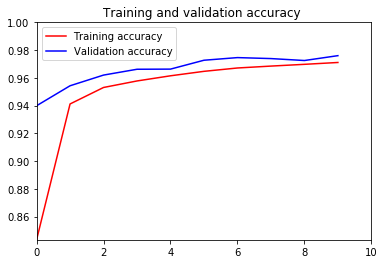

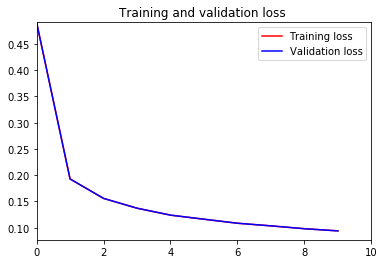

<Figure size 432x288 with 0 Axes>

In [98]:
def keras_two_layer_cnn():
    # Load MNIST data set
    # Note that Keras expects the sample index to be the first dimension whereas in our
    # framework it was last. This is why we rearrange the dimensions of the data
    X_train, Y_train, X_validation, Y_validation = load_mnist()
    X_train = X_train.transpose((3,0,1,2))
    X_validation = X_validation.transpose((3,0,1,2))

    n_c = 10
        
    # Build the model
    model = Sequential([
        Input((28, 28, 1)),                           # (28,28,1) Input volume
        Conv2D(filters=6, kernel_size=(5, 5)),        # Conv layer with 6 (5,5) filters
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)), # MaxPooling with (2,2) pool regions and nonoverlapping stride
        Conv2D(filters=2, kernel_size=(3,3)),         # Conv layer with 2 (3,3) filters
        Activation('relu'),
        Flatten(),
        Dense(10),                                    # Final 10 output softmax layer
        Activation('softmax'),
    ])

    # Compile the model to use categorial cross entropy loss, 
    # and Mini-Batch Stochastic Gradient Descent Optimizer with a learning rate of 0.1
    optimizer = optimizers.SGD(lr=0.1)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, 
                        one_hot(Y_train, n_c).T, 
                        validation_data=(X_validation, one_hot(Y_validation, n_c).T), 
                        epochs=10, 
                        batch_size=128)

    plot_training_history(history)


keras_two_layer_cnn()

In the above cell we only ran the training for 10 epochs.  Judging from the plots, it looks like progress could still be made if we let the training run for longer. Instead of having you wait, here are the plots and results for if you run the training for 100 epochs.

The final stats after 100 epochs are as follows:

    - training loss:       0.0477 
    - validation loss:     0.0730

    - training accuracy:   0.9845 
    - validation accuracy: 0.9780
    
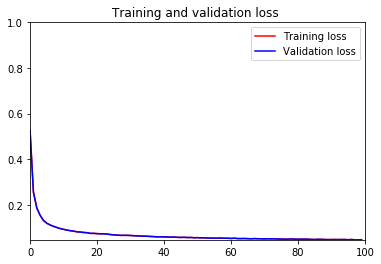

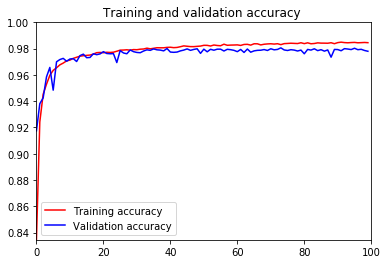

This CNN can achieve high training and validation accuracy on the entire MNIST data set. As with most real problems, validation accuracy will lag behind training accuracy. Whether this is a issue depends on the problem you are trying to solve and the acceptable accuracy you should have ddetermined ahead of time.  If the gap is large (which it is not in this case), then it would mean that your model is overfitting the data.  More on these topics in lecture soon!


## 3.2. Implementing Lenet5 Architecture in Keras

Recall that the classic Lenet5 architecture, while quite small, was designed to perform well on the MNIST data set.  Let's experiment with it.  Complete the following function that creates a Keras model that models the Lenet5 architecture.  Recall that the Lenet5 architecture is as follows:

- Conv: 6 (5,5) filters
- MaxPool: (2,2) non-overlapping stride
- Conv: 16 (5,5) filters
- MaxPool: (2,2) non-overlapping stride
- Fully Connected: 120 units
- Fully Connected: 84 units
- Fully Connected Softmax output layer

You should be able to simply follow the previous code cell and add the appropriate Keras layers. Note that although the original Lenet5 used tanh activation functions and Averge Pooling, you should use relu and MaxPooling for this assignment.

In [106]:
# GRADED FUNCTION: create_lenet5_model

def create_lenet5_model(input_shape):
    model = Sequential([
        Input(input_shape),

        ### START CODE HERE (~8 lines of code) ###
        # YOUR CODE HERE
        
        Conv2D(filters=6, kernel_size=(5, 5)),        # Conv layer with 6 (5,5) filters
        MaxPooling2D(pool_size=(2,2), strides=(2,2)), # MaxPooling with (2,2) pool regions and nonoverlapping stride
        Conv2D(filters=16, kernel_size=(5, 5)),        # Conv layer with 16 (5,5) filters
        MaxPooling2D(pool_size=(2,2), strides=(2,2)), # MaxPooling with (2,2) pool regions and nonoverlapping stride
        Flatten(),
        Dense(120), Activation('relu'),
        Dense(84), Activation('relu'),
        Dense(10), Activation('softmax'), # Final 10 output softmax layer        
          
        ### END CODE HERE ###
    ])
    return model


### 3.3. Lenet5 on MNIST Data Set

Let's train our Lenet5 model on the MNIST data set.  Run the following code cell. 

X (training)   shape: (28, 28, 1, 60000)
Y (training)   shape: (60000,)
X (validation) shape: (28, 28, 1, 10000)
Y (validation) shape: (10000,)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 38s 636us/sample - loss: 0.3258 - accuracy: 0.8982 - val_loss: 0.1110 - val_accuracy: 0.9649
Epoch 2/5
60000/60000 [==============================] - 38s 640us/sample - loss: 0.0930 - accuracy: 0.9707 - val_loss: 0.0976 - val_accuracy: 0.9695
Epoch 3/5
60000/60000 [==============================] - 38s 635us/sample - loss: 0.0650 - accuracy: 0.9797 - val_loss: 0.0532 - val_accuracy: 0.9826
Epoch 4/5
60000/60000 [==============================] - 38s 627us/sample - loss: 0.0501 - accuracy: 0.9843 - val_loss: 0.0478 - val_accuracy: 0.9853
Epoch 5/5
60000/60000 [==============================] - 42s 695us/sample - loss: 0.0409 - accuracy: 0.9870 - val_loss: 0.0600 - val_accuracy: 0.9809


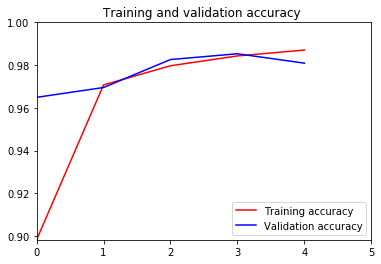

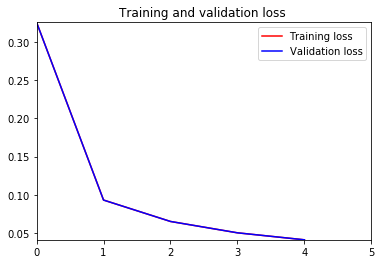

<Figure size 432x288 with 0 Axes>

In [107]:
def keras_lenet5_mnist():    
    # Load MNIST data set
    # Note that Keras expects the sample index to be the first dimension whereas in our
    # framework it was last. This is why we rearrange the dimensions of the data
    X_train, Y_train, X_validation, Y_validation = load_mnist()
    X_train = X_train.transpose((3,0,1,2))
    X_validation = X_validation.transpose((3,0,1,2))

    n_c = 10

    # Create our Lenet5 Keras Model and tell it to expect a (28,28,1) input volume
    model = create_lenet5_model((28, 28, 1))

    # Compile the model to use categorial cross entropy loss, 
    # and Mini-Batch Stochastic Gradient Descent Optimizer with a learning rate of 0.1
    optimizer = optimizers.SGD(lr=0.1)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, 
                        one_hot(Y_train, n_c).T, 
                        validation_data=(X_validation, one_hot(Y_validation, n_c).T), 
                        epochs=5, 
                        batch_size=128)

    plot_training_history(history)

    return history
history = keras_lenet5_mnist()


Like before, we only ran the training for 5 epochs. Feel free to increase the number of epochs and watch it train, but to save you time, we have provided the results for 100 epochs.

The final results are as follows:

    - training loss:       3.2470e-05  
    - validation loss:     0.0603 

    - training accuracy:   1.0000
    - validation accuracy: 0.9895

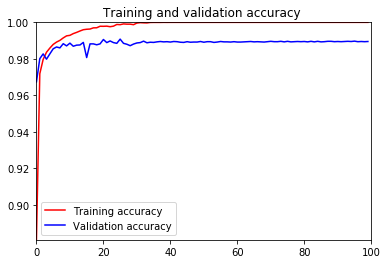

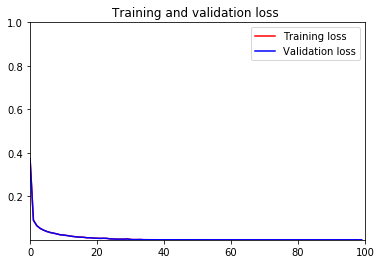

This model achieved 100% training accuracy. More importantly, it increased our validation accuracy by slightly over 1%. As expected, our architectural choices matter!  

## 3.4. Lenet5 For CIFAR10

Let's now move to a different data set.  We will now train the Lenet5 architecture on the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) data set.  This is another toy dataset for object classification. 

Similarities to MNIST:
- 10 classes
- 50,000 training images
- 10,000 validation images

Differences from MNIST:
- 32x32 color images
- Pictures of real world objects

Here are some examples from each of the 10 classes.

<!-- ![cifar10_examples.png](cifar10_examples.png) -->

<div>
<img src="cifar10_examples.png" width="400"/>
</div>
<!-- <div>
<img src="attachment:image.png" width="400"/>
</div> -->

Knowing how Lenet5 performes on MNIST data set, how would you expect it to do on CIFAR10? Will it achieve similar training and validation accuracy? Think about this for a minute and then let's see whether your intution is correct.

Run the following cell to train Lenet5 model on CIFAR10.

170500096/170498071 [==============================] - 3s 0us/step
X (training)   shape: (32, 32, 3, 50000)
Y (training)   shape: (50000,)
X (validation) shape: (32, 32, 3, 10000)
Y (validation) shape: (10000,)

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 64s 1ms/sample - loss: 1.8906 - accuracy: 0.3179 - val_loss: 1.6054 - val_accuracy: 0.4221
Epoch 2/5
50000/50000 [==============================] - 58s 1ms/sample - loss: 1.5355 - accuracy: 0.4498 - val_loss: 1.4303 - val_accuracy: 0.4849
Epoch 3/5
50000/50000 [==============================] - 57s 1ms/sample - loss: 1.3819 - accuracy: 0.5075 - val_loss: 1.3543 - val_accuracy: 0.5234
Epoch 4/5
50000/50000 [==============================] - 60s 1ms/sample - loss: 1.2863 - accuracy: 0.5434 - val_loss: 1.3700 - val_accuracy: 0.5236
Epoch 5/5
50000/50000 [==============================] - 58s 1ms/sample - loss: 1.2084 - accuracy: 0.5700 - val_loss: 1.2617 - val_accuracy: 0.560

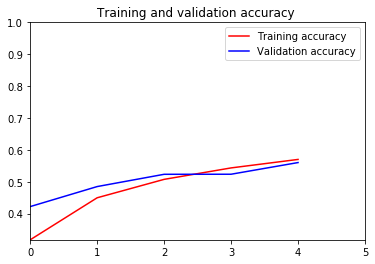

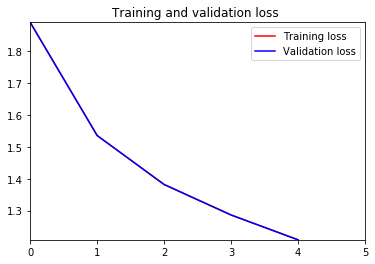

<Figure size 432x288 with 0 Axes>

In [109]:
def keras_lenet5_cifar10():
    import tensorflow
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Input, Flatten
    from tensorflow.keras.initializers import RandomNormal, he_normal
    from tensorflow.keras import optimizers

    # Load CIFAR10 data set
    # Note that Keras expects the sample index to be the first dimension whereas in our
    # framework it was last. This is why we rearrange the dimensions of the data
    X_train, Y_train, X_validation, Y_validation = load_cifar10()
    X_train = X_train.transpose((3,0,1,2))
    X_validation = X_validation.transpose((3,0,1,2))
    
    n_c = 10
    
    # Create our Lenet5 Keras model and tell it to expect an input volume of (32,32,3)
    model = create_lenet5_model((32, 32, 3))

    # Compile the model to use categorial cross entropy loss, 
    # and Mini-Batch Stochastic Gradient Descent Optimizer with a learning rate of 0.1
    optimizer = optimizers.SGD(lr=0.1)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, 
                        one_hot(Y_train, n_c).T, 
                        validation_data=(X_validation, one_hot(Y_validation, n_c).T), 
                        epochs=5, 
                        batch_size=128)

    plot_training_history(history)

        
keras_lenet5_cifar10()

Once again, we only ran for 5 epochs and show you the results after 100 epochs.

The final results are as follows.  How do the results compare to your expectations?

    - training loss:       0.3652  
    - validation loss:     3.0113

    - training accuracy:   0.8753
    - validation accuracy: 0.5305

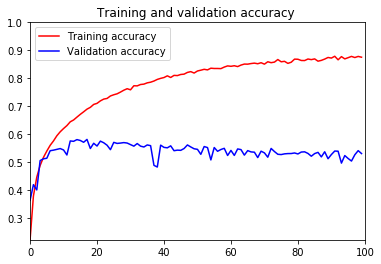


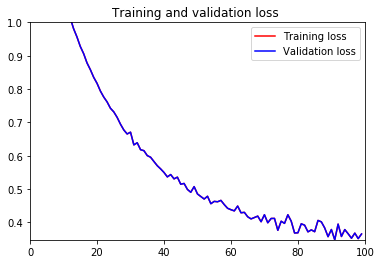

Training accuracy tops out around 87.5%. The model achieved 100% training accuracy on the MNIST set. Some reasons for why training accuracy to top out:

1. An optimization problem. i.e. there are better parameter values out there but we just weren't able to find them. Maybe we could try different hyperparmeters related to the training (e.g. learning rate, flavour of gradient descent, weight initialization, etc.)
2. The architecture doesn't have enough capacity. i.e. this is the best that this architecture can achieve.  We could try adding more layers, adding more filters per conv layer, pooling less aggressively, etc.

Without too much further investigation, I would hypothesize that it is very likely that our model doesn't have enough capacity.  But why did the model work well for MNIST? The biggest difference is variety of visual features that make up the images in MNIST versus CIFAR10.  In MNIST, you could imagine that the only features of interest are various types of lines as we are only trying to understand handwritten digits. In CIFAR10, you could imagine that the features that make up an image in the Airplane class, and an image in the Dog class are quite different (we can refer to this as inter-class variation). Furthermore, there is also a lot of intra-class variation. Different images within the same class (e.g. Dog class) may look very different, and the model would need to know about different features just to understand different pictures of dogs.

A few other challenges posed by CIFAR10 images is that its images have background details (more features that the model needs to learn to ignore), and the objects are 3D objects. Recall that we talked about how CNNs are not tolerant to any (except translation) geometric transformations of the input image.  If you understand this, you should be able to reason that CNNs are definitely not tolerant to understanding all the different ways that the same 3D object can be projected onto a 2D plane (i.e. photographed). There are so many variations due to the position of the camera with respect to the object and lighting.

Another thing we can notice from the above plots is that there is a significant gap between validation accuracy (53%) and training accuracy (87.5%). This means that although the model managed to make some progress in learning the discriminating features within the training set, the things that were learned did not generalize well. Many of the same issues we discussed in the previous paragraph also apply here. We can also see that the validation accuracy slowly gets worse after about 20 training epochs as the model continues to overfit further. In practice, you would get your training accuracy to an acceptable level first before trying to improve your validation accuracy. Various regularization techniques can be employed to encourage the model to learn to generalize.  We will cover this topic in more detail in lecture after CNNs.


# 4. Mainstream Architectures in Keras

Often times, a good place to start for a computer vision deep learning solution is trying out one of the mainstream architectures.  We talked about a number of these architectures in lecture (e.g. VGGNet, ResNet, Inception).  To save you from manually specifying these mainstream architectures, Keras has many of them pre-defined.  The following architectures are available in Keras:

- Xception
- VGG16
- VGG19
- ResNet
- ResNetV2
- InceptionV3
- InceptionResNetV2
- MobileNet
- MobileNetV2
- DenseNet
- NASNet

Furthermore, their ImageNet trained weights are also available!

This final section is just a quick demo on how to load these architectures and use them.

To read more about the available models and some ways to use them, see the [official docs](https://keras.io/applications/)


## 4.1. Using ResNet with ImageNet trained weights for classification

The next code cell will load the ResNet50 architecture with ImageNet weights.  We will then supply the following picture of a frog and print the top 10 predictions and their probabilities for the image.

![frog.jpg](frog.jpg)



In [110]:
import tensorflow
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

# Load the model with weights
model = ResNet50(weights='imagenet')

# Prepare the image
img_path = 'frog.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Make a prediction
preds = model.predict(x)

# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch, but we are only supplying one sample)
print('Prediction:')
for _, label, prob in decode_predictions(preds, top=10)[0]:
    print('{0:0.10f}: {1}'.format(prob, label))



102973440/102967424 [==============================] - 5s 0us/step
Prediction:
40960/35363 [==================================] - 0s 0us/step
0.9889302850: tree_frog
0.0106881447: tailed_frog
0.0001716191: bullfrog
0.0000459916: African_chameleon
0.0000309314: leaf_beetle
0.0000197356: mantis
0.0000162074: grasshopper
0.0000127926: leafhopper
0.0000103504: green_lizard
0.0000097913: weevil


If you want to try your own photo, go back to your JupyterHub file system and upload a photo. Then change the filename in the above code cell and rerun.

## 4.2. Extracting Final Volume from VGG16 with ImageNet Weights

As discussed in lecture, we can view the convolutional layers as a "feature extractor" for an image.  The final volume, once flattened, can be interpreted as an encoding or a feature vector describing the image. In this example, we load a VGG16 model along with its ImageNet trained weights.  The difference is that we set the 'include_top' parameter to False so as to not include the final Softmax output layer of the model. This way, the final output of the model will be the final convolutional layer.  We then supply the same frog image from the previous section to the model. The output is the final volume values for this image.

In [112]:
import tensorflow

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

# Load the model and weights 
# but do not include the final softmax and fully connected layers
model = VGG16(weights='imagenet', include_top=False)

# Prepare the input image
img_path = 'frog.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Make a prediction. Now the output is the final convolutional volume
features = model.predict(x)
print('Final Volume Shape:', features.shape)

58892288/58889256 [==============================] - 2s 0us/step
Final Volume Shape: (1, 7, 7, 512)


## 5 Conclusion

Congratulations you have extended our, from scratch, deep learning framework to support Convolutional Neural Networks, and learned how to use an industry framework to work with CNNs!

In this assignment, you have:

- Extended our deep learning framework to support Convolutional Neural Networks
- Implemented forward propagation and back propagation in a modular fashion for Convolution, Maxpooling, and Flatten layer types.
- Train convolutional neural networks with our custom framework
- Use Keras to build and train convolutional neural networks
- Use Keras to work with mainstream CNN architectures such as ResNet, and VGG


## 6 Summary of Graded Functions

- convolve()
- conv_forward_propagate()
- conv_backward_propagate()
- maxpool_forward_propagate()
- maxpool_backward_propagate()
- flatten_forward_propagate()
- flatten_backward_propagate()
- create_lenet5_model()

Thank you to Singulos Research for feedback, suggestions, and testing of this assignment.